In [53]:
COMPARISONS = ['Lesion_Double_deep_tMPPCA_5D', 'Lesion_Double_tMPPCA_5D', 'Lesion_Double_GT']

#COMPARISONS = ['Tumor_1_tMPPCA_5D', 'Tumor_1_deep_tMPPCA_5D','Tumor_1_FullRank_deep', 'Tumor_1_noisy']

#COMPARISONS = ['Tumor_2_tMPPCA_5D', 'Tumor_2_deep_tMPPCA_5D','Tumor_2_noisy']

#COMPARISONS = ['P08_noisy', 'P08_deep_tMPPCA_5D', 'P08_tMPPCA_5D'] 

quality_clip = False # show voxels that meet LC Model quality criteria
outlier_clip = False
clip_pct = 2.0 # entfernt oberste 2% der fehlerpixl um außreißer zu vermeiden

z= 11 #9

# Available methods:
# - P08_noDenoising
# - P08_LR8
# - P08_unet_JInvariant
# - P08_zfT

# - P08_simulated_GT   -- that is ground truth
# - P08_simulated_noisy
# - P08_simulated_LR8
# - P08_simulated_unet_JInvariant

# - Sim_GT_lesion
# - Sim_lesion_deep
# - Sim_lesion_LR8
# - Sim_lesion_noisy

# Note I fitted many more methods, the result of which are in my home directory: /ceph/mri.meduniwien.ac.at/departments/radiology/mrsbrain/home/hfischer

In [54]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.metrics import structural_similarity as ssim
from cmcrameri import cm

def _metrics(img, ref, clip_pct: float | None = None):
    """Berechnet **relativen RMSE** (rRMSE ∈ [0, 1] bei Min‑Max‑Norm), PSNR (dB) und
    SSIM zwischen zwei 2‑D‑Arrays. Optionale Outlier‑Entfernung über *clip_pct*.

    Args:
        img:   Testbild (2‑D NumPy‑Array)
        ref:   Referenzbild (2‑D NumPy‑Array)
        clip_pct: Prozent der Pixel mit größtem |Fehler|, die ignoriert werden (z. B. 2).
                  None ⇒ kein Trimmen.

    Returns:
        tuple(rRMSE, psnr, ssim_val)
    """
    # gültige Pixel
    mask = np.isfinite(img) & np.isfinite(ref)
    if not np.any(mask):
        return np.nan, np.nan, np.nan

    a, b = img[mask], ref[mask]
    err  = a - b

    # Trimming: oberste *clip_pct* Fehler entfernen
    if clip_pct is not None and 0 < clip_pct < 100:
        thr  = np.percentile(np.abs(err), 100 - clip_pct)
        keep = np.abs(err) <= thr
        a, b = a[keep], b[keep]
        err  = err[keep]

    # RMSE
    mse  = np.mean(err ** 2)
    rmse = np.sqrt(mse)

    # ----- relativer RMSE (Min‑Max‑Normalisierung) -----
    span = b.max() - b.min()
    rrmse = rmse / span if span > 0 else np.nan  # ∈ [0,1] falls Fehler ≤ Span

    # PSNR (nutzt absoluten RMSE, wie üblich)
    peak = b.max() if span > 0 else 1.0  # fallback
    psnr = 20 * np.log10(peak / rmse) if rmse > 0 else np.inf

    # SSIM (maskiert Outlier analog zum Error‑Mask‑Trimming)
    full_mask = mask.copy()
    if clip_pct is not None and 0 < clip_pct < 100:
        full_mask &= (np.abs(img - ref) <= thr)
    ssim_val = ssim(np.nan_to_num(img), np.nan_to_num(ref), data_range=span if span > 0 else 1.0, mask=full_mask)

    return rrmse, psnr, ssim_val


import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

def plot_metab_maps(
        metabolite: str,
        methods: list[str],
        quality_clip: bool = False,
        outlier_clip: bool = False,
        clip_pct: float | None = None,
        z: int = z,
        data_dir: str = "MetabMaps",
        scale: str = 'global',      # 'auto' | 'global' | 'percentile' | 'column'
        percentile: tuple[float, float] = (2, 98)
    ) -> None:
    """Visualisiert AMP-Karten und SD-Quotienten mit flexiblem Scaling.

    scale:
      - 'auto'       -> imshow-Autoskalierung pro Bild
      - 'global'     -> ein gemeinsames Min/Max über alle AMP-Maps
      - 'percentile' -> **per-column** (Methode) vmin/vmax nach Perzentilen
      - 'column'     -> per-column Min/Max + eigene Colorbar
    """
    suffix = "OutlierClip" if outlier_clip else ("QualityClip" if quality_clip else "Orig")

    amps, sds = {}, {}
    for m in methods:
        tag    = f"{m}_{suffix}"
        folder = os.path.join(data_dir, m)
        amp_f  = os.path.join(folder, f"{metabolite}_amp_{tag}.npy")
        sd_f   = os.path.join(folder, f"{metabolite}_sd_{tag}.npy")

        if os.path.isfile(amp_f): amps[m] = np.load(amp_f)
        else: print(f"❌ AMP fehlt: {amp_f}")
        if os.path.isfile(sd_f):  sds[m]  = np.load(sd_f)
        else: print(f"⚠️ SD fehlt:  {sd_f}")

    if not amps:
        raise FileNotFoundError("Keine AMP-Dateien gefunden.")

    amp_slice = {k: v[z, ...] for k, v in amps.items()}  # (H, W, T)

    # ---- Skalierungs-Setup ----
    global_vmin = global_vmax = None
    vmin_col, vmax_col = {}, {}

    all_imgs = np.stack(list(amp_slice.values()), axis=0)  # (M, H, W, T)
    if scale == 'global':
        global_vmin = np.nanmin(all_imgs)
        global_vmax = np.nanmax(all_imgs)
    elif scale == 'percentile':
        # NEU: per-column Percentiles
        p_lo, p_hi = percentile
        for k in methods:
            a = amp_slice[k]
            vmin_col[k] = np.nanpercentile(a, p_lo)
            vmax_col[k] = np.nanpercentile(a, p_hi)
    elif scale == 'column':
        for k in methods:
            a = amp_slice[k]
            vmin_col[k] = np.nanmin(a)
            vmax_col[k] = np.nanmax(a)
    # else 'auto': alles None -> imshow-Auto

    # ---- SD-Quotient (letzte/vrletzte Methode) ----
    ratio_key = None
    if len(methods) >= 2 and methods[-1] in sds and methods[-2] in sds:
        ratio_key = f"{methods[-1]}/{methods[-2]}"
        with np.errstate(divide="ignore", invalid="ignore"):
            ratio = sds[methods[-1]][z] / sds[methods[-2]][z]
            ratio[np.isinf(ratio)] = np.nan

    keys = methods + ([ratio_key] if ratio_key else [])
    plot_cols = len(keys)

    # Layout: bei 'column' **oder** 'percentile' je Spalte eigene Colorbar
    if scale in ('column', 'percentile'):
        cb_cols = plot_cols
    else:
        cb_cols = 1 + (1 if ratio_key else 0)

    total_cols = plot_cols + cb_cols
    width_ratios = [1] * plot_cols + [0.2] * cb_cols

    T = amps[methods[0]].shape[-1]
    fig = plt.figure(figsize=(4 * plot_cols + 2, 24))
    gs  = gridspec.GridSpec(T, total_cols, width_ratios=width_ratios, wspace=0.3)

    ims_first = {}
    ref_key = methods[-1]

    cb_ax_map = {}
    if scale in ('column', 'percentile'):
        for i, key in enumerate(keys):
            cb_ax_map[key] = fig.add_subplot(gs[:, plot_cols + i])

    for t in range(T):
        ref_img = amp_slice[ref_key][..., t]
        for c, key in enumerate(keys):
            ax = fig.add_subplot(gs[t, c])
            if key != ratio_key:
                img = amp_slice[key][..., t]
                if scale in ('column', 'percentile'):
                    vmin = vmin_col.get(key, None)
                    vmax = vmax_col.get(key, None)
                else:
                    vmin = global_vmin
                    vmax = global_vmax

                im  = ax.imshow(img, cmap="plasma", vmin=vmin, vmax=vmax)
                if key != ref_key:
                    rrmse, psnr, ss = _metrics(img, ref_img, clip_pct)
                    title_metrics = f"rRMSE:{rrmse:.3f} PSNR:{psnr:.1f} SSIM:{ss:.2f}"
                else:
                    title_metrics = "Referenz"
                ax.set_title(f"{metabolite} {key}, T={t+1}\n{title_metrics}", fontsize=8)
            else:
                im = ax.imshow(ratio[..., t], cmap="plasma")
                ax.set_title(f"SD {ratio_key}, T={t+1}", fontsize=8)

            ax.axis("off")
            if t == 0:
                ims_first[key] = im

    # ---- Colorbars ----
    if scale in ('column', 'percentile'):
        for key in keys:
            cax = cb_ax_map[key]
            cb  = fig.colorbar(ims_first[key], cax=cax)
            label = f"{metabolite} AMP" if key != ratio_key else f"{metabolite} SD-Ratio"
            cb.set_label(label)
            cax.yaxis.set_ticks_position("right")
    else:
        cax_amp = fig.add_subplot(gs[:, plot_cols])
        cb_amp = fig.colorbar(ims_first[methods[0]], cax=cax_amp)
        cb_amp.set_label(f"{metabolite} AMP")
        cax_amp.yaxis.set_ticks_position("right")

        if ratio_key:
            cax_ratio = fig.add_subplot(gs[:, plot_cols+1])
            cb_ratio = fig.colorbar(ims_first[ratio_key], cax=cax_ratio)
            cb_ratio.set_label(f"{metabolite} SD-Ratio")
            cax_ratio.yaxis.set_ticks_position("right")

    plt.tight_layout(rect=[0,0,0.95,1])
    plt.savefig('MetabMaps.jpg', dpi=200, bbox_inches='tight')
    plt.show()



def plot_metab_ratio(
    metab1: str,
    metab2: str,
    methods: list[str],
    quality_clip: bool = False,
    outlier_clip: bool = False,
    z: int = z,
    data_dir: str = "MetabMaps",
    scale: str = 'percentile',      # 'auto' | 'global' | 'percentile' | 'column' | 'manual'
    percentile: tuple[float, float] = (2, 98),
    vmin_manual: float = None,      # NEU: manuelles Minimum
    vmax_manual: float = None       # NEU: manuelles Maximum
) -> None:
    """Plottet das Verhältnis AMP(metab1)/AMP(metab2) für mehrere Methoden.
       'percentile' wirkt jetzt **global** (ein gemeinsamer Wertebereich & eine Colorbar).
       'column' wirkt pro Spalte (jede Spalte eigene Colorbar).
       'manual' erlaubt eine benutzerdefinierte Skala über vmin_manual/vmax_manual.
    """
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib import gridspec

    suffix = "OutlierClip" if outlier_clip else ("QualityClip" if quality_clip else "Orig")

    ratios = {}
    for m in methods:
        folder = os.path.join(data_dir, m)
        f1 = os.path.join(folder, f"{metab1}_amp_{m}_{suffix}.npy")
        f2 = os.path.join(folder, f"{metab2}_amp_{m}_{suffix}.npy")

        if not os.path.isfile(f1):
            print(f"❌ AMP fehlt: {f1}")
            continue
        if not os.path.isfile(f2):
            print(f"❌ AMP fehlt: {f2}")
            continue

        amp1 = np.load(f1)[z, ...]
        amp2 = np.load(f2)[z, ...]
        with np.errstate(divide="ignore", invalid="ignore"):
            ratio = amp1 / amp2
            ratio[np.isinf(ratio)] = np.nan
        ratios[m] = ratio

    if not ratios:
        raise FileNotFoundError("Keine Ratio-Maps gefunden.")

    methods_plotted = list(ratios.keys())

    # ---- Skalierung ----
    vmin = vmax = None
    vmin_col, vmax_col = {}, {}

    if scale == 'manual':
        vmin, vmax = vmin_manual, vmax_manual

    elif scale == 'global':
        all_imgs = np.stack([ratios[m] for m in methods_plotted], axis=0)
        vmin, vmax = np.nanmin(all_imgs), np.nanmax(all_imgs)

    elif scale == 'percentile':
        p_lo, p_hi = percentile
        all_imgs = np.stack([ratios[m] for m in methods_plotted], axis=0)
        vmin, vmax = np.nanpercentile(all_imgs, p_lo), np.nanpercentile(all_imgs, p_hi)

    elif scale == 'column':
        for m in methods_plotted:
            r = ratios[m]
            vmin_col[m] = np.nanmin(r)
            vmax_col[m] = np.nanmax(r)
    # else: 'auto' -> None

    # ---- Layout ----
    n_methods = len(methods_plotted)
    n_T = next(iter(ratios.values())).shape[-1]
    cb_cols = n_methods if scale == 'column' else 1
    total_cols = n_methods + cb_cols
    width_ratios = [1]*n_methods + [0.2]*cb_cols

    fig = plt.figure(figsize=(4 * n_methods + 2, 4 * n_T))
    gs = gridspec.GridSpec(n_T, total_cols, width_ratios=width_ratios, wspace=0.3)

    ims_first = {}
    cb_ax_map = {}
    if scale == 'column':
        for i, m in enumerate(methods_plotted):
            cb_ax_map[m] = fig.add_subplot(gs[:, n_methods + i])

    # ---- Plots ----
    for c, m in enumerate(methods_plotted):
        ratio = ratios[m]
        for t in range(n_T):
            ax = fig.add_subplot(gs[t, c])
            if scale == 'column':
                vmin_m, vmax_m = vmin_col[m], vmax_col[m]
            else:
                vmin_m, vmax_m = vmin, vmax

            im = ax.imshow(ratio[..., t], cmap=cm.batlow, vmin=vmin_m, vmax=vmax_m)
            ax.set_title(f"{metab1}/{metab2}\n{m}, T={t+1}", fontsize=8)
            ax.axis("off")
            if t == 0:
                ims_first[m] = im

    # ---- Colorbars ----
    if scale == 'column':
        for m in methods_plotted:
            cax = cb_ax_map[m]
            cb = fig.colorbar(ims_first[m], cax=cax)
            cb.set_label(f"{metab1}/{metab2} Ratio ({m})")
            cax.yaxis.set_ticks_position("right")
    else:
        cax = fig.add_subplot(gs[:, -1])
        cb = fig.colorbar(next(iter(ims_first.values())), cax=cax)
        cb.set_label(f"{metab1}/{metab2} Ratio")
        cax.yaxis.set_ticks_position("right")

    plt.tight_layout(rect=[0,0,0.95,1])
    plt.savefig(f"MetabRatio_{metab1}_{metab2}.jpg", dpi=200, bbox_inches='tight')
    plt.show()

# Wasser

In [55]:
# plot_metab_maps(
#     metabolite='water',
#     methods=COMPARISONS,
#     quality_clip=False,
#     outlier_clip=outlier_clip,
#     clip_pct=clip_pct  # entfernt oberste 2% der Fehlerpixel
# )

# Glc

/tmp/ipykernel_880980/753478314.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,0.95,1])


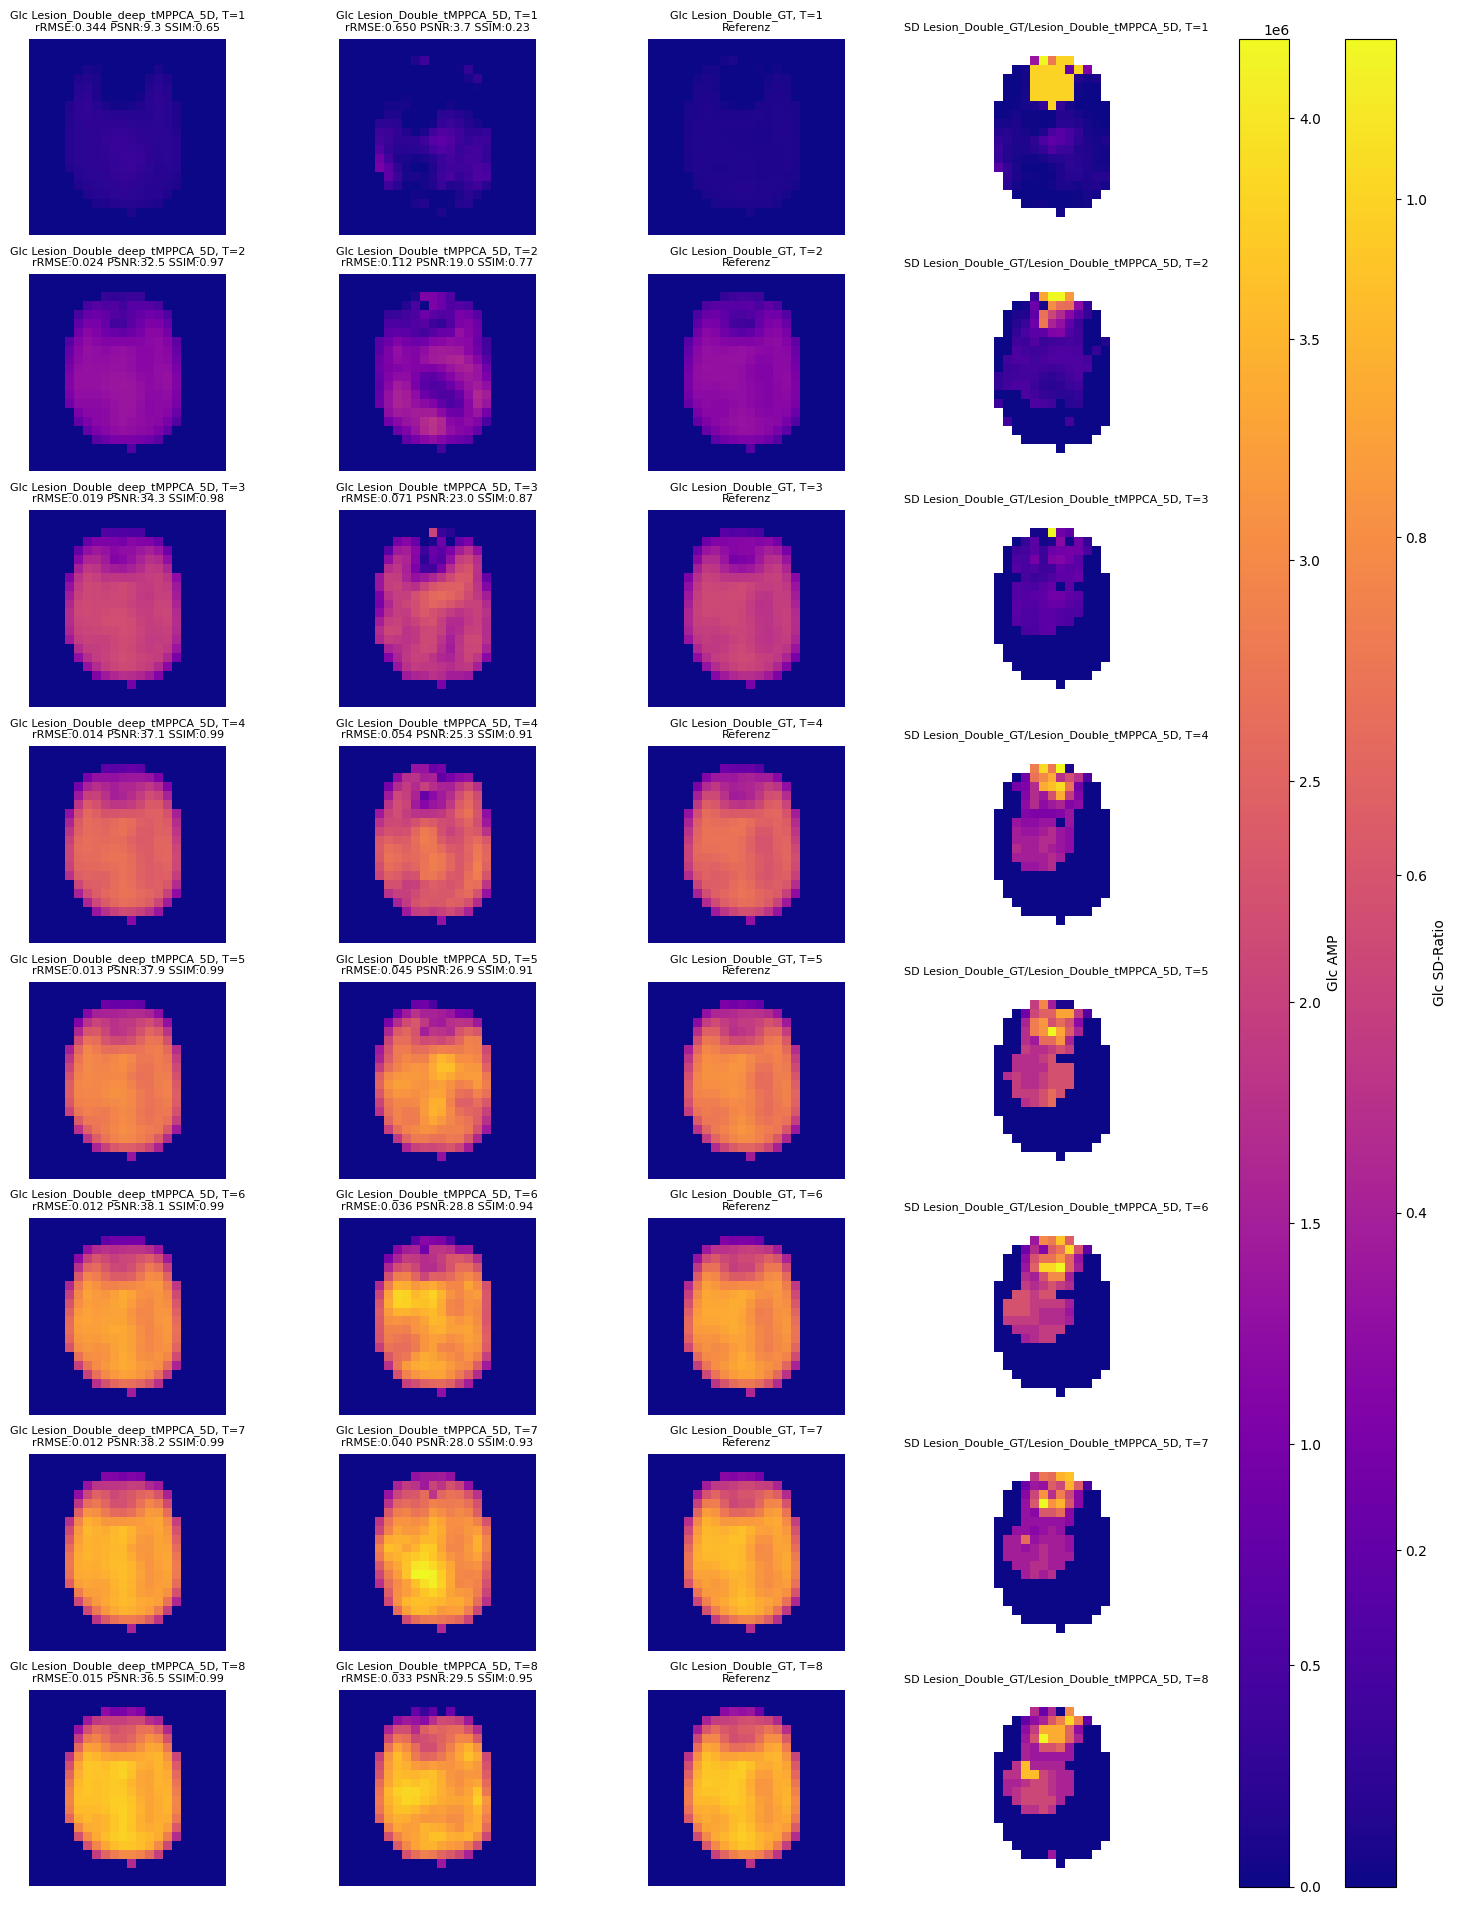

In [56]:
plot_metab_maps(
    metabolite='Glc',
    methods=COMPARISONS,
    quality_clip=False,
    outlier_clip=outlier_clip,
    clip_pct=clip_pct  # entfernt oberste 2% der Fehlerpixel
)

# Glx

/tmp/ipykernel_880980/753478314.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,0.95,1])


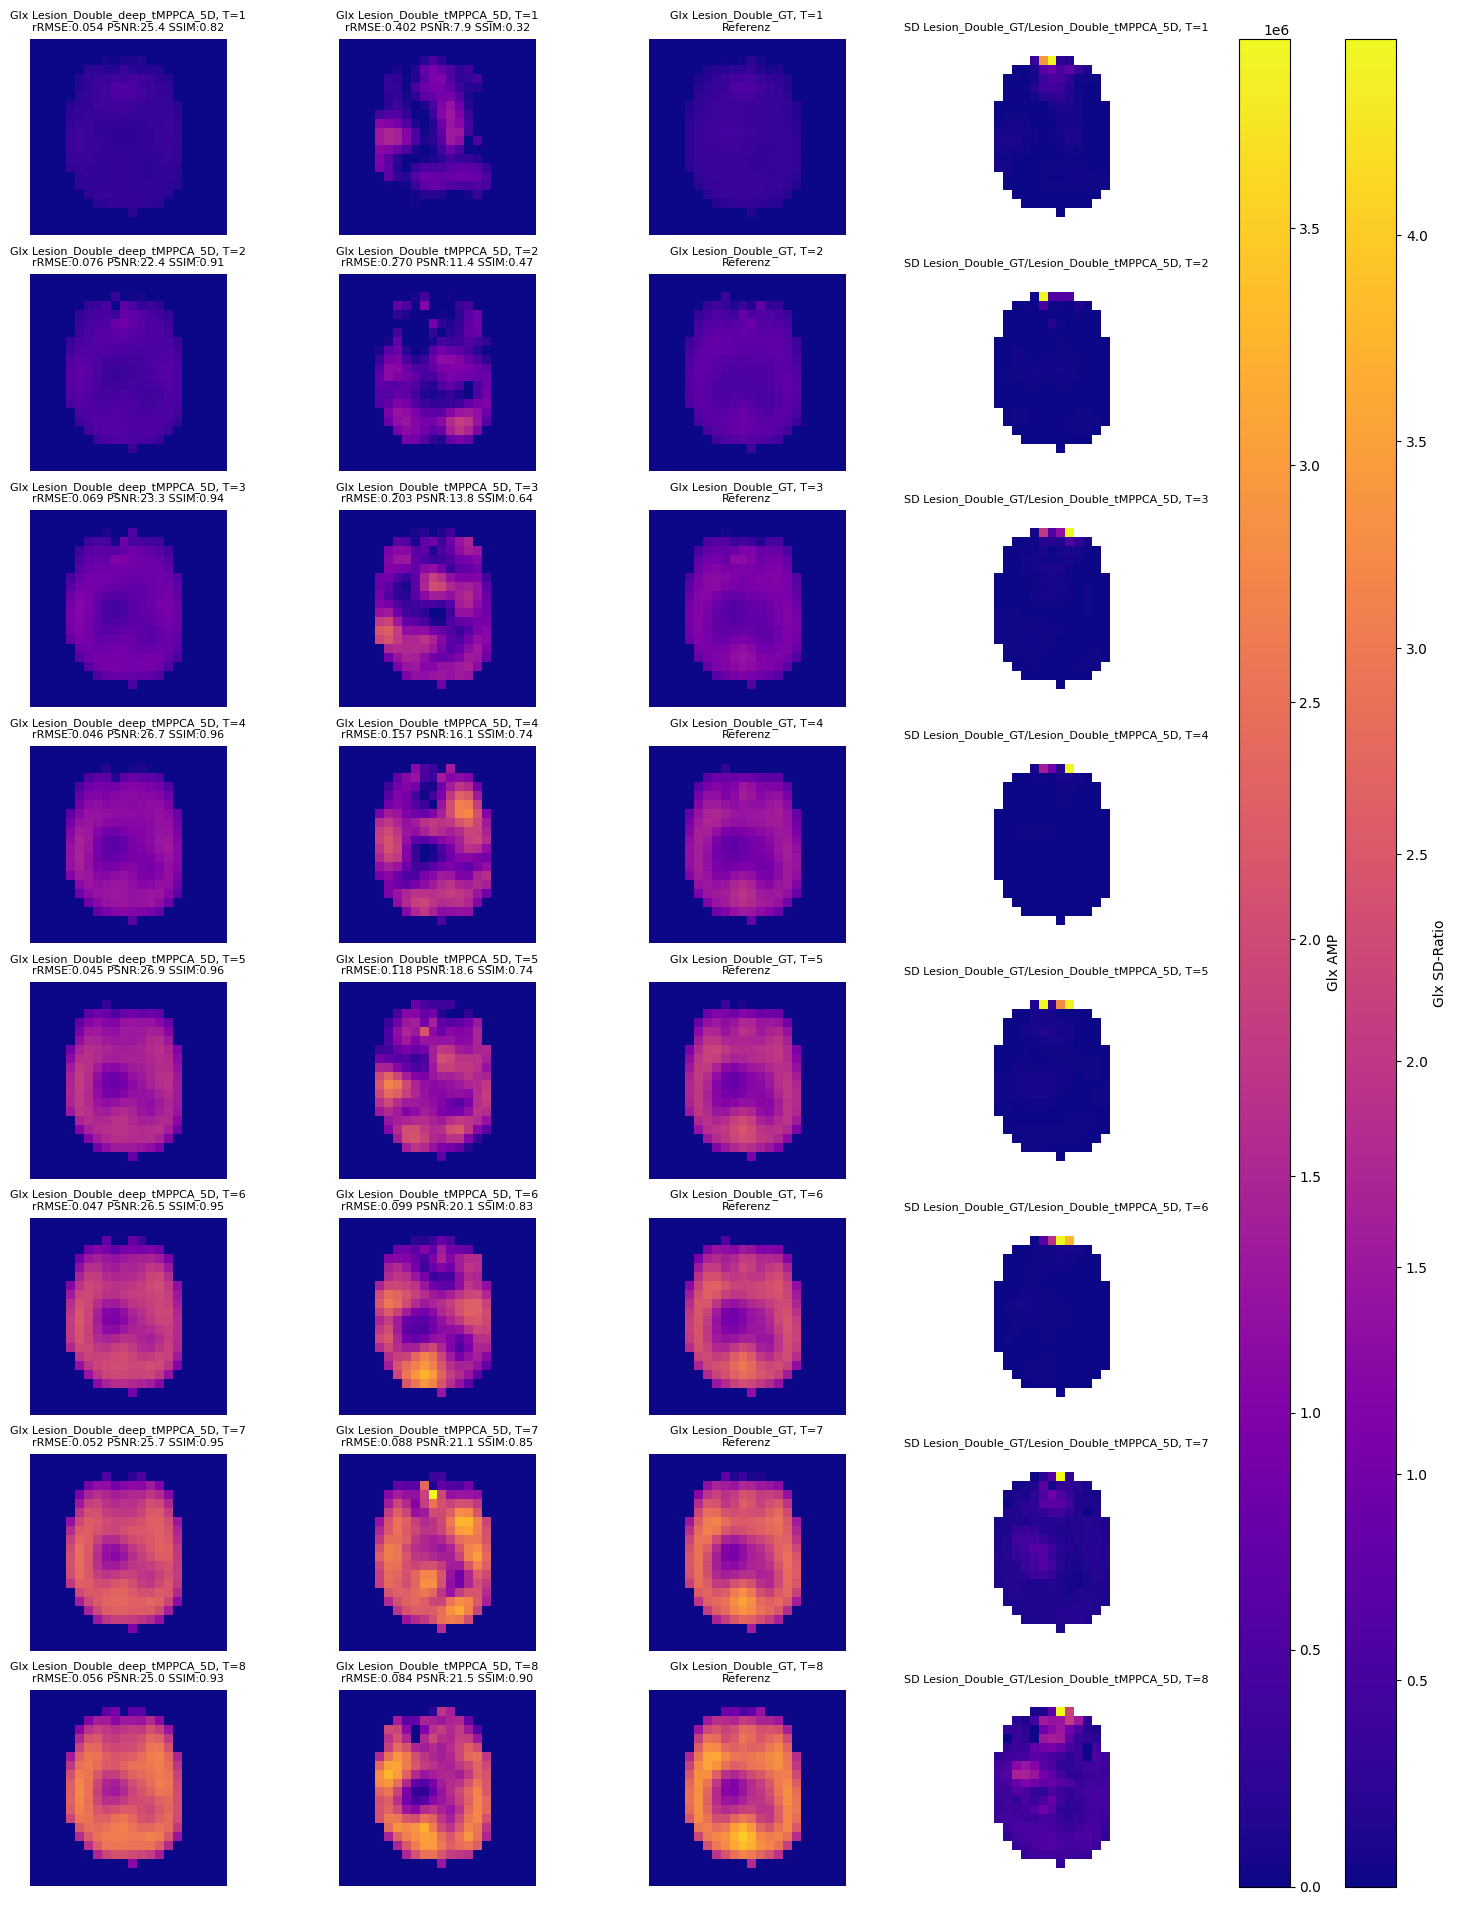

In [57]:
plot_metab_maps(
    metabolite='Glx',
    methods=COMPARISONS,
    quality_clip=quality_clip,
    outlier_clip=outlier_clip,
    clip_pct=clip_pct # entfernt oberste 2% der Fehlerpixel
)


# Lac

/tmp/ipykernel_880980/753478314.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,0.95,1])


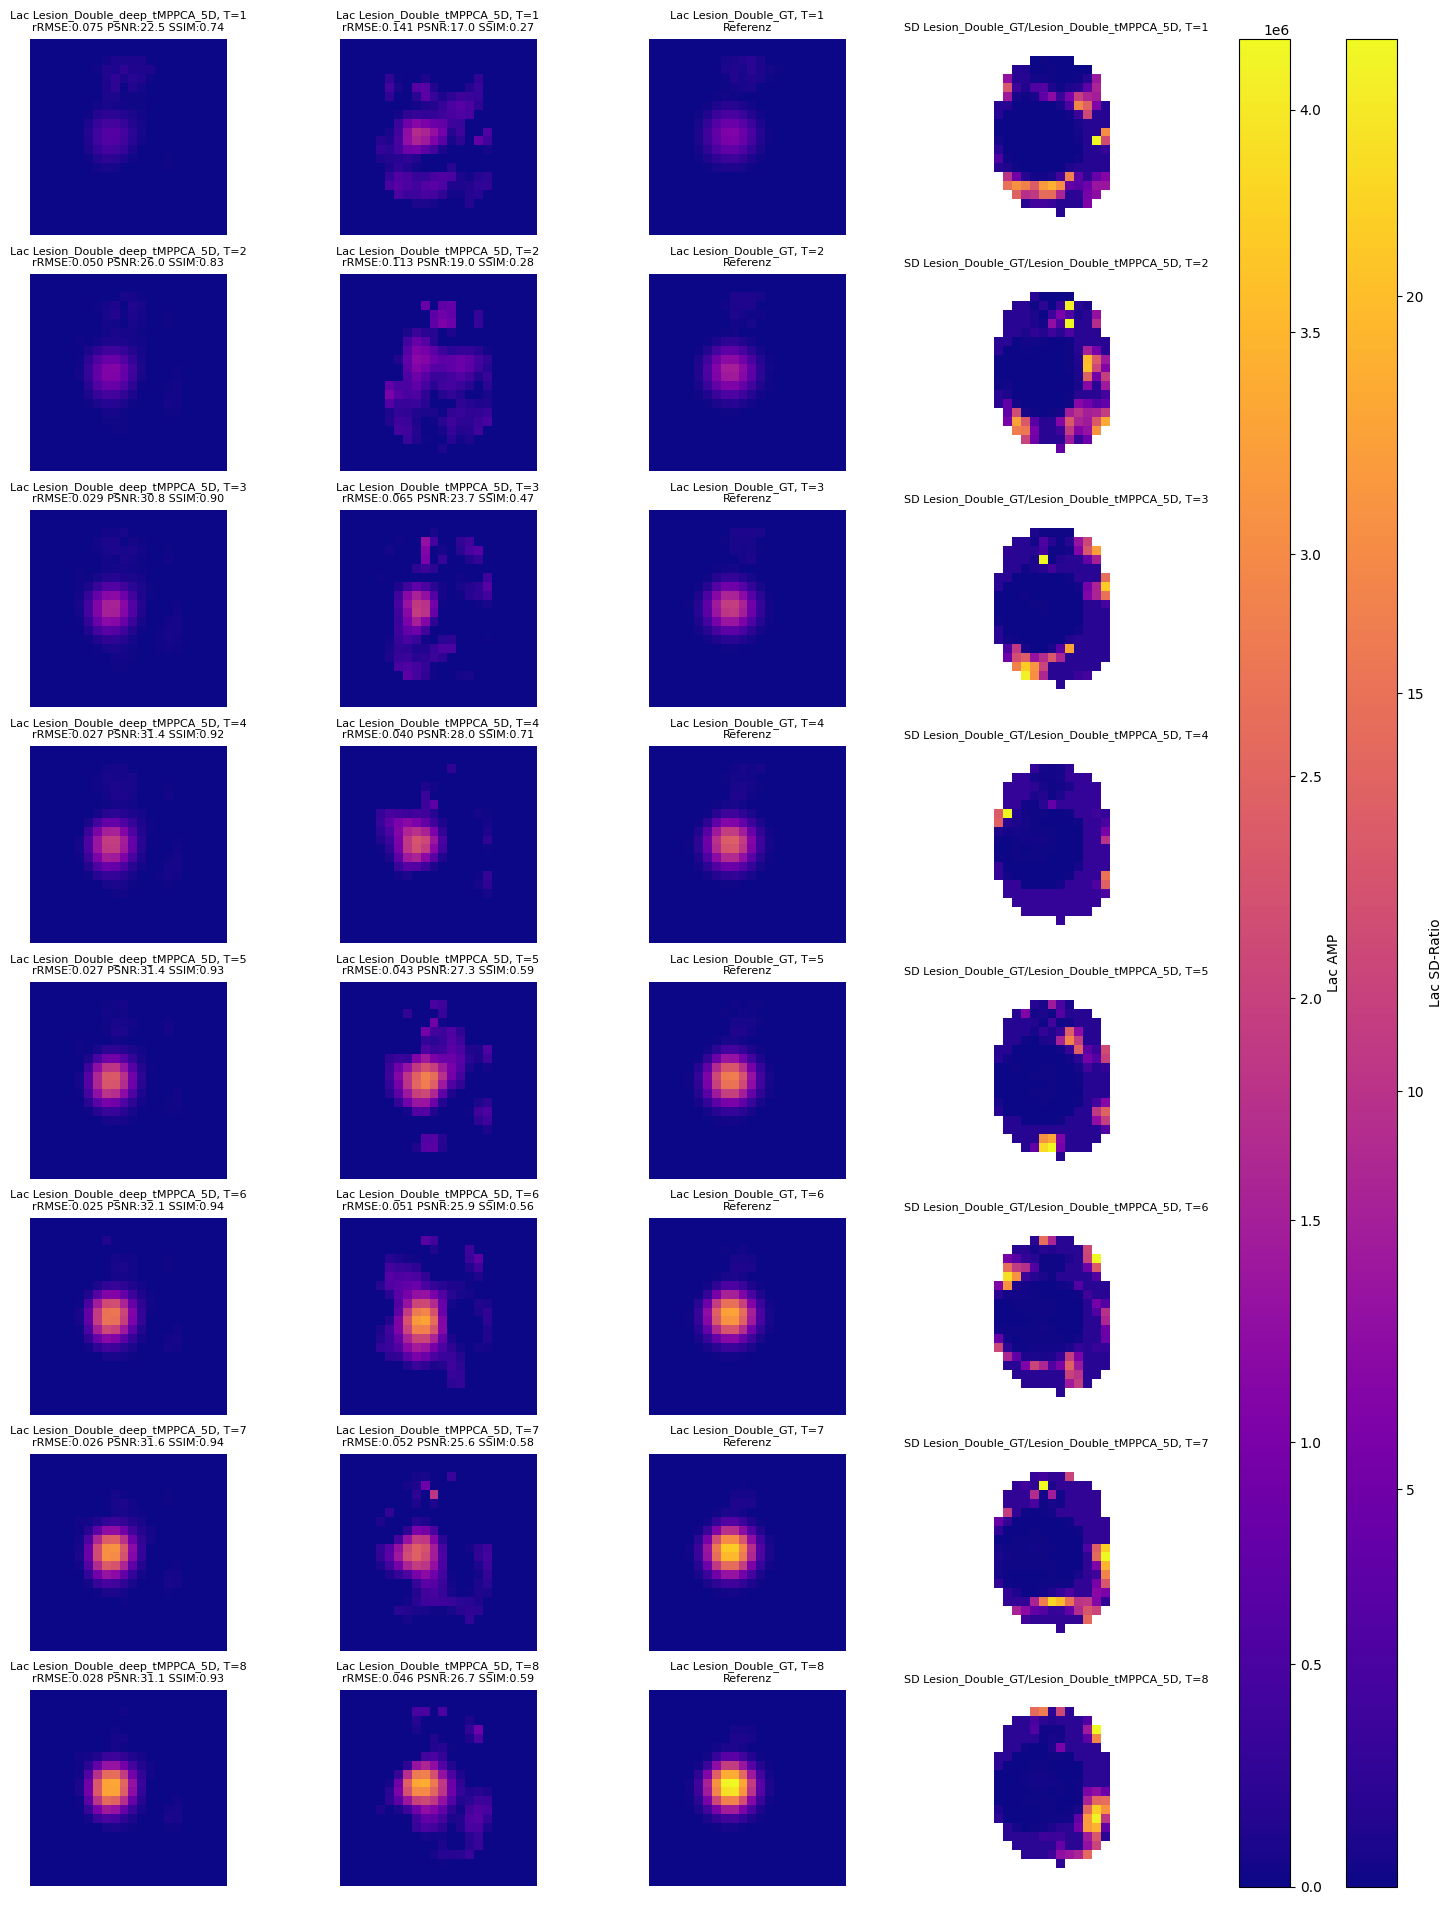

In [58]:
plot_metab_maps(
    metabolite='Lac',
    methods=COMPARISONS,
    quality_clip=quality_clip,
    outlier_clip=outlier_clip,
    clip_pct=clip_pct  # entfernt oberste 2% der Fehlerpixel
)


/tmp/ipykernel_880980/753478314.py:326: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,0.95,1])


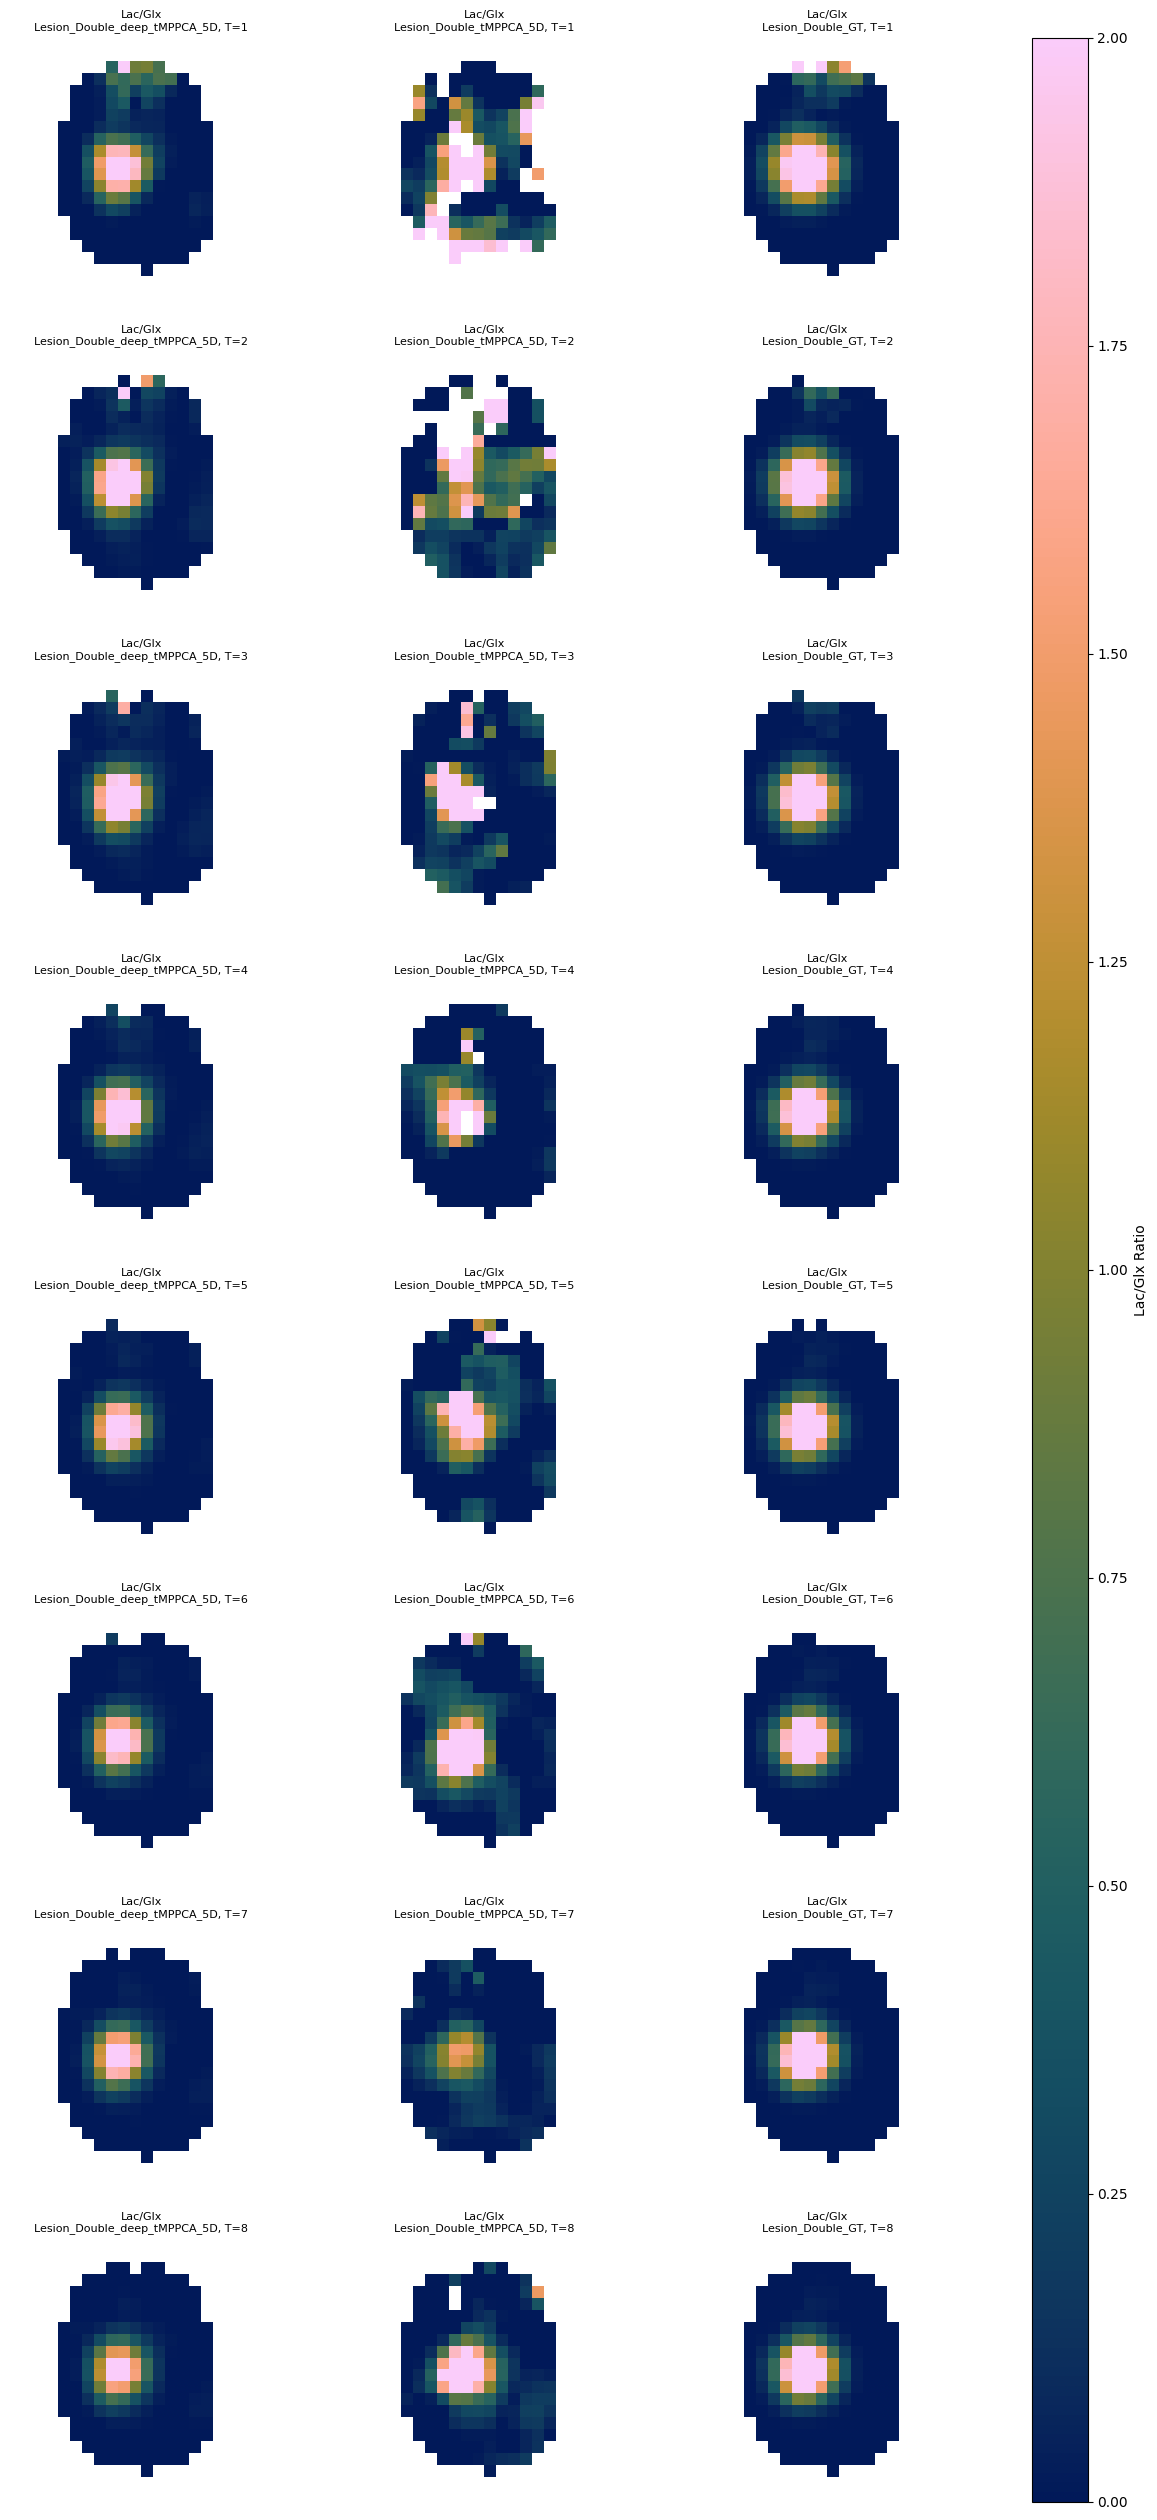

In [59]:
plot_metab_ratio(
    metab1="Lac",           # Numerator-Metabolit
    metab2="Glx",           # Denominator-Metabolit
    methods=COMPARISONS,  # zu vergleichende Methoden
    quality_clip=False,
    scale="manual",
    vmin_manual= 0,      # NEU: manuelles Minimum
    vmax_manual= 2
)

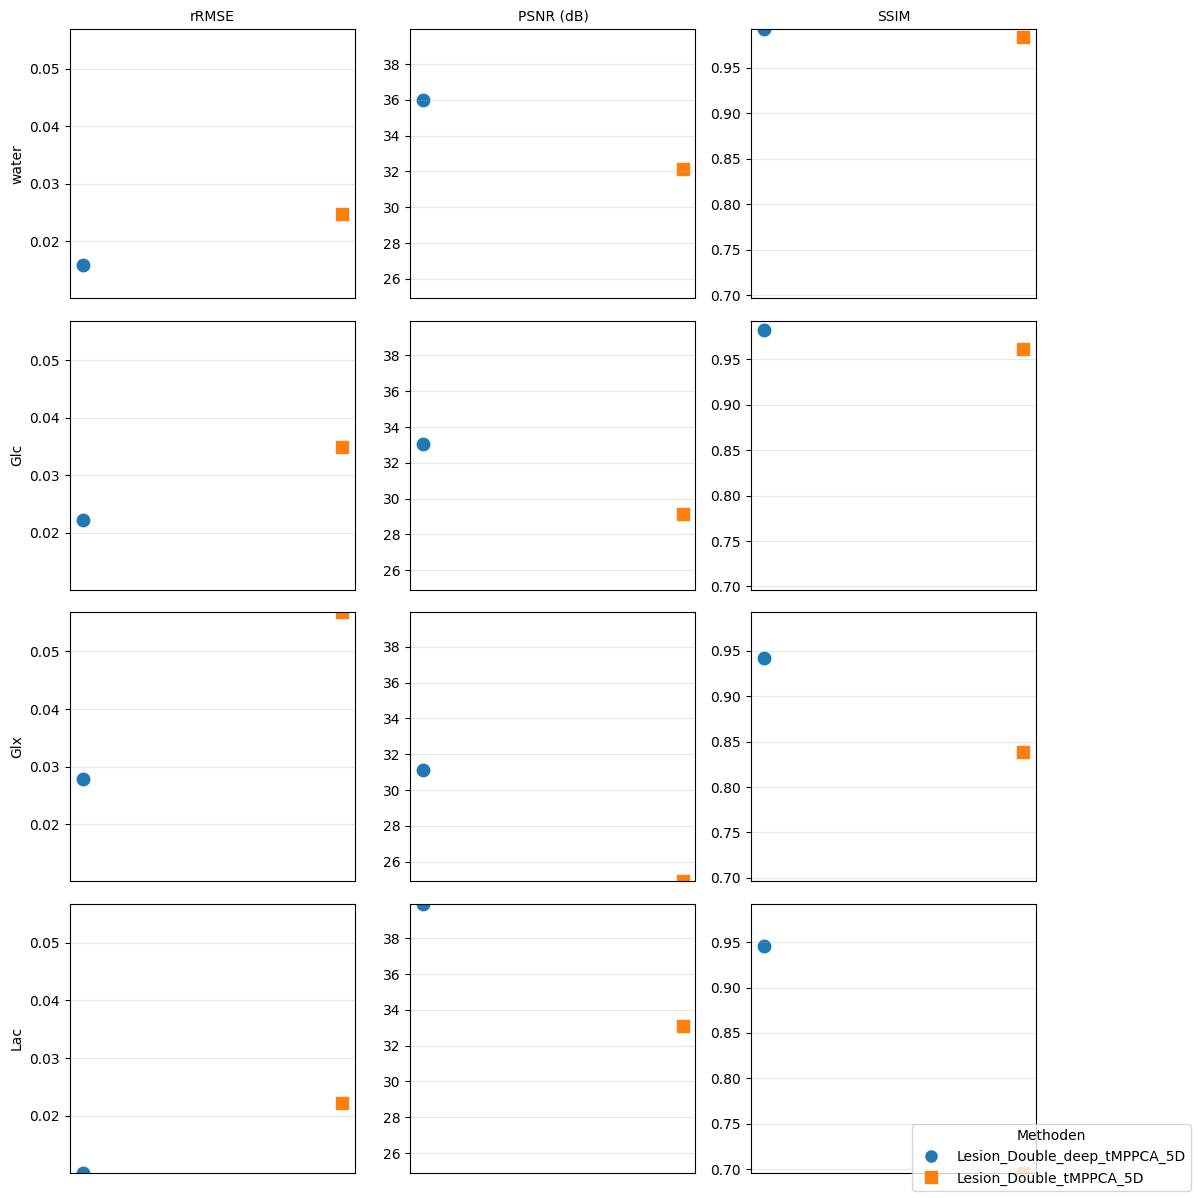

In [60]:
from __future__ import annotations
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim


def vol_metrics(vol: np.ndarray, ref: np.ndarray) -> tuple[float, float, float]:
    """Berechnet rRMSE, PSNR und SSIM für zwei 3D-Volumes."""
    mask = np.isfinite(vol) & np.isfinite(ref)
    if not mask.any():
        return np.nan, np.nan, np.nan
    a = vol[mask]
    b = ref[mask]
    err = a - b
    rmse = np.sqrt(np.mean(err**2))
    span = b.max() - b.min()
    rrmse = rmse / span if span else np.nan
    psnr = 20 * np.log10(b.max() / rmse) if rmse else np.inf
    ssimv = ssim(np.nan_to_num(vol), np.nan_to_num(ref), data_range=span or 1.0)
    return rrmse, psnr, ssimv


def scatter_metrics_grid(
    metabolites: list[str],
    methods: list[str],                   # letzte Methode = Ground Truth
    data_dir: str = "MetabMaps",
    suffix: str = "Orig",                   # optionaler Suffix ohne führenden Unterstrich
) -> None:
    """
    Scatter-Grid für volumetrische Qualitätsmetriken:
      Zeilen: Metabolite
      Spalten: rRMSE, PSNR (dB), SSIM
      Punkte: Methoden (Legende)

    Ground Truth (methods[-1]) wird nur als Referenz geladen, nicht geplottet.
    Suffix wird nur angehängt, wenn nicht leer.
    """
    if len(methods) < 2:
        raise ValueError("Mindestens zwei Methoden benötigt (inkl. Ground Truth).")

    plot_methods = methods[:-1]
    gt = methods[-1]
    sep = f"_{suffix}" if suffix else ""

    # 1) Metriken sammeln
    metrics: dict[str, dict[str, tuple[float, float, float]]] = {m: {} for m in metabolites}
    for metab in metabolites:
        # Ground Truth laden
        gt_file = os.path.join(data_dir, gt, f"{metab}_amp_{gt}{sep}.npy")
        if not os.path.isfile(gt_file):
            print(f"❌ GT fehlt für {metab}: {gt_file}")
            continue
        ref_vol = np.load(gt_file)
        # Methoden durchlaufen
        for meth in plot_methods:
            meth_file = os.path.join(data_dir, meth, f"{metab}_amp_{meth}{sep}.npy")
            if not os.path.isfile(meth_file):
                print(f"⚠️ Methode fehlt: {meth_file}")
                continue
            vol = np.load(meth_file)
            metrics[metab][meth] = vol_metrics(vol, ref_vol)

    # 2) Gemeinsame Min/Max pro Metrik bestimmen
    rr_all = [metrics[mb][m][0] for mb in metabolites for m in plot_methods if m in metrics[mb]]
    ps_all = [metrics[mb][m][1] for mb in metabolites for m in plot_methods if m in metrics[mb]]
    ss_all = [metrics[mb][m][2] for mb in metabolites for m in plot_methods if m in metrics[mb]]
    rr_min, rr_max = (min(rr_all), max(rr_all)) if rr_all else (0, 1)
    ps_min, ps_max = (min(ps_all), max(ps_all)) if ps_all else (0, 1)
    ss_min, ss_max = (min(ss_all), max(ss_all)) if ss_all else (0, 1)

    # 3) Plot erstellen
    n_rows = len(metabolites)
    n_cols = 3  # rRMSE, PSNR, SSIM
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), squeeze=False)
    metric_names = ["rRMSE", "PSNR (dB)", "SSIM"]

    colors = plt.cm.tab10(range(len(plot_methods)))
    markers = ["o", "s", "D", "^", "v", "P", "X"]

    for r, metab in enumerate(metabolites):
        for c in range(n_cols):
            ax = axes[r][c]
            for i, meth in enumerate(plot_methods):
                if meth not in metrics[metab]:
                    continue
                y = metrics[metab][meth][c]
                ax.scatter(i, y,
                           color=colors[i], marker=markers[i % len(markers)], s=80)
            # Titel und Achsen
            if r == 0:
                ax.set_title(metric_names[c], fontsize=10)
            if c == 0:
                ax.set_ylabel(metab, fontsize=10)
            ax.set_xticks([])
            # Gemeinsame Skala pro Spalte
            if c == 0:
                ax.set_ylim(rr_min, rr_max)
            elif c == 1:
                ax.set_ylim(ps_min, ps_max)
            else:
                ax.set_ylim(ss_min, ss_max)
            ax.grid(alpha=0.3)

    # 4) Gemeinsame Legende
    handles = [plt.Line2D([], [], marker=markers[i % len(markers)], color=colors[i], linestyle='',
                          label=meth, markersize=8)
               for i, meth in enumerate(plot_methods)]
    fig.legend(handles, [hm.get_label() for hm in handles], loc='lower right', title='Methoden')

    plt.tight_layout(rect=[0, 0, 0.88, 1])
    plt.show()



metabolites = ["water", "Glc", "Glx", "Lac"]
# methods = ["UNet", "WALINET"]
METABS  = ["water", "Glc", "Glx", "Lac"]
METHODS = COMPARISONS  # letzer Eintrag = Ground‑Truth
scatter_metrics_grid(METABS, METHODS)

# Conversions

In [ ]:
import os
import nibabel as nib
import numpy as np

#############################################
metabolites = {'water', 'Glc', 'Glx', 'Lac'}
variants = {
    'Orig': 'Orig',
    'QualityAndOutlier_Clip': 'QualityClip',
    'Outlier_Clip': 'OutlierClip'
}
data_dir   = "MetabMaps"
model_base = ''    ##COMPARISONS = ['Tumor_2_tMPPCA_5D', 'Tumor_2_deep_tMPPCA_5D','Tumor_2_noisy']
#############################################

# Ziel-Unterordner anlegen
output_dir = os.path.join(data_dir, model_base)
os.makedirs(output_dir, exist_ok=True)

for folder, suffix in variants.items():
    model = f"{model_base}_{suffix}"

    for metabolite in metabolites:
        amp_list = []
        sd_list  = []

        for i in range(1, 9):
            # Dateinamen auf Basis der Variante
            amp_file = os.path.join(
                data_dir,
                f"{metabolite}_amp_map_{i}_{suffix}.mnc"
            )
            sd_file = os.path.join(
                data_dir,
                f"{metabolite}_sd_map_{i}_{suffix}.mnc"
            )

            # AMP-Datei laden
            if os.path.exists(amp_file):
                amp_img  = nib.load(amp_file)
                amp_data = amp_img.get_fdata()
                amp_list.append(amp_data)
            else:
                print(f"❌ Datei fehlt: {amp_file}")

            # SD nur für Orig
            if folder == 'Orig':
                if os.path.exists(sd_file):
                    sd_img  = nib.load(sd_file)
                    sd_data = sd_img.get_fdata()
                    sd_list.append(sd_data)
                else:
                    print(f"❌ Datei fehlt: {sd_file}")

        # Speichern AMP
        if amp_list:
            amp_stacked = np.stack(amp_list, axis=-1)
            print(f"{metabolite} AMP shape ({suffix}): {amp_stacked.shape}")
            np.save(
                os.path.join(
                    output_dir,
                    f"{metabolite}_amp_{model}.npy"
                ),
                amp_stacked#/np.float32(10885.352)
            )

        # Speichern SD (nur für Orig)
        if folder == 'Orig' and sd_list:
            sd_stacked = np.stack(sd_list, axis=-1)
            print(f"{metabolite} SD shape ({suffix}): {sd_stacked.shape}")
            np.save(
                os.path.join(
                    output_dir,
                    f"{metabolite}_sd_{model}.npy"
                ),
                sd_stacked
            )

# Alle .mnc-Dateien löschen
for filename in os.listdir(data_dir):
    if filename.endswith(".mnc"):
        full_path = os.path.join(data_dir, filename)
        os.remove(full_path)
        print(f"🗑️ Gelöscht: {full_path}")


❌ Datei fehlt: MetabMaps/Glc_amp_map_1_Orig.mnc
❌ Datei fehlt: MetabMaps/Glc_sd_map_1_Orig.mnc
❌ Datei fehlt: MetabMaps/Glc_amp_map_2_Orig.mnc
❌ Datei fehlt: MetabMaps/Glc_sd_map_2_Orig.mnc
❌ Datei fehlt: MetabMaps/Glc_amp_map_3_Orig.mnc
❌ Datei fehlt: MetabMaps/Glc_sd_map_3_Orig.mnc
❌ Datei fehlt: MetabMaps/Glc_amp_map_4_Orig.mnc
❌ Datei fehlt: MetabMaps/Glc_sd_map_4_Orig.mnc
❌ Datei fehlt: MetabMaps/Glc_amp_map_5_Orig.mnc
❌ Datei fehlt: MetabMaps/Glc_sd_map_5_Orig.mnc
❌ Datei fehlt: MetabMaps/Glc_amp_map_6_Orig.mnc
❌ Datei fehlt: MetabMaps/Glc_sd_map_6_Orig.mnc
❌ Datei fehlt: MetabMaps/Glc_amp_map_7_Orig.mnc
❌ Datei fehlt: MetabMaps/Glc_sd_map_7_Orig.mnc
❌ Datei fehlt: MetabMaps/Glc_amp_map_8_Orig.mnc
❌ Datei fehlt: MetabMaps/Glc_sd_map_8_Orig.mnc
❌ Datei fehlt: MetabMaps/water_amp_map_1_Orig.mnc
❌ Datei fehlt: MetabMaps/water_sd_map_1_Orig.mnc
❌ Datei fehlt: MetabMaps/water_amp_map_2_Orig.mnc
❌ Datei fehlt: MetabMaps/water_sd_map_2_Orig.mnc
❌ Datei fehlt: MetabMaps/water_amp_map_3_O

# Conversions SNR map + Spectra + FWHM

In [2]:
import os
import numpy as np
import nibabel as nib

#############################################
data_dir   = "MetabMaps"            # hier liegen die kopierten Dateien
model_base = ""
timepoints = list(range(1, 11))     # 1..10
CANONICAL  = True                   # nach RAS+ kanonisieren (empfohlen)
#############################################

output_dir = os.path.join(data_dir, model_base)
os.makedirs(output_dir, exist_ok=True)

def load_img(path, canonical=CANONICAL):
    img = nib.load(path)
    return nib.as_closest_canonical(img) if canonical else img

def affine_equal(a, b, atol=1e-5):
    return np.allclose(a, b, atol=atol)

# ---------- FWHM (mnc) ----------
fwhm_list, fwhm_srcs = [], []
fwhm_aff0 = None
for t in timepoints:
    fp = os.path.join(data_dir, f"FWHM_map_{t}.mnc")
    if not os.path.exists(fp):
        print(f"❌ fehlt: {fp}")
        continue
    img = load_img(fp)
    if fwhm_aff0 is None:
        fwhm_aff0 = img.affine
    elif not affine_equal(img.affine, fwhm_aff0):
        print(f"⚠️  AFFINE-Mismatch (FWHM) bei t={t}")
    fwhm_list.append(img.get_fdata())
    fwhm_srcs.append(fp)

if fwhm_list:
    fwhm_arr = np.stack(fwhm_list, axis=-1).astype(np.float32)
    print("FWHM shape:", fwhm_arr.shape)
    np.save(os.path.join(output_dir, f"FWHM_{model_base}.npy"), fwhm_arr)
    for p in fwhm_srcs:
        os.remove(p)
        print(f"🗑️ gelöscht: {p}")

# ---------- SNR (mnc) ----------
snr_list, snr_srcs = [], []
snr_aff0 = None
for t in timepoints:
    fp = os.path.join(data_dir, f"SNR_map_{t}.mnc")
    if not os.path.exists(fp):
        print(f"❌ fehlt: {fp}")
        continue
    img = load_img(fp)
    if snr_aff0 is None:
        snr_aff0 = img.affine
    elif not affine_equal(img.affine, snr_aff0):
        print(f"⚠️  AFFINE-Mismatch (SNR) bei t={t}")
    snr_list.append(img.get_fdata())
    snr_srcs.append(fp)

if snr_list:
    snr_arr = np.stack(snr_list, axis=-1).astype(np.float32)
    print("SNR shape:", snr_arr.shape)
    np.save(os.path.join(output_dir, f"SNR_{model_base}.npy"), snr_arr)
    for p in snr_srcs:
        os.remove(p)
        print(f"🗑️ gelöscht: {p}")

# ---------- Spektren (nii.gz) ----------
spec_list, spec_srcs = [], []
spec_aff0 = None
for t in timepoints:
    fp = os.path.join(data_dir, f"SpecMap_LCMInput_{t}.nii.gz")
    if not os.path.exists(fp):
        print(f"❌ fehlt: {fp}")
        continue
    img = load_img(fp)
    data = img.get_fdata()
    if spec_aff0 is None:
        spec_aff0 = img.affine
    elif not affine_equal(img.affine, spec_aff0):
        print(f"⚠️  AFFINE-Mismatch (Spec) bei t={t}")
    spec_list.append(data)
    spec_srcs.append(fp)

if spec_list:
    shapes = [d.shape for d in spec_list]
    if len(set(shapes)) != 1:
        print(f"⚠️  Uneinheitliche Spektren-Shapes: {shapes}")
    spec5d = np.stack(spec_list, axis=-1).astype(np.float32)
    print("Spectra 5D shape:", spec5d.shape)
    np.save(os.path.join(output_dir, f"Spectra_{model_base}.npy"), spec5d)
    for p in spec_srcs:
        os.remove(p)
        print(f"🗑️ gelöscht: {p}")

print("✅ Fertig.")



❌ fehlt: MetabMaps/FWHM_map_9.mnc
❌ fehlt: MetabMaps/FWHM_map_10.mnc
FWHM shape: (22, 22, 21, 8)
🗑️ gelöscht: MetabMaps/FWHM_map_1.mnc
🗑️ gelöscht: MetabMaps/FWHM_map_2.mnc
🗑️ gelöscht: MetabMaps/FWHM_map_3.mnc
🗑️ gelöscht: MetabMaps/FWHM_map_4.mnc
🗑️ gelöscht: MetabMaps/FWHM_map_5.mnc
🗑️ gelöscht: MetabMaps/FWHM_map_6.mnc
🗑️ gelöscht: MetabMaps/FWHM_map_7.mnc
🗑️ gelöscht: MetabMaps/FWHM_map_8.mnc
❌ fehlt: MetabMaps/SNR_map_9.mnc
❌ fehlt: MetabMaps/SNR_map_10.mnc
SNR shape: (22, 22, 21, 8)
🗑️ gelöscht: MetabMaps/SNR_map_1.mnc
🗑️ gelöscht: MetabMaps/SNR_map_2.mnc
🗑️ gelöscht: MetabMaps/SNR_map_3.mnc
🗑️ gelöscht: MetabMaps/SNR_map_4.mnc
🗑️ gelöscht: MetabMaps/SNR_map_5.mnc
🗑️ gelöscht: MetabMaps/SNR_map_6.mnc
🗑️ gelöscht: MetabMaps/SNR_map_7.mnc
🗑️ gelöscht: MetabMaps/SNR_map_8.mnc
❌ fehlt: MetabMaps/SpecMap_LCMInput_9.nii.gz
❌ fehlt: MetabMaps/SpecMap_LCMInput_10.nii.gz
Spectra 5D shape: (22, 22, 21, 163, 8)
🗑️ gelöscht: MetabMaps/SpecMap_LCMInput_1.nii.gz
🗑️ gelöscht: MetabMaps/SpecMap